In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import pickle
from cvxopt import matrix, sparse, solvers

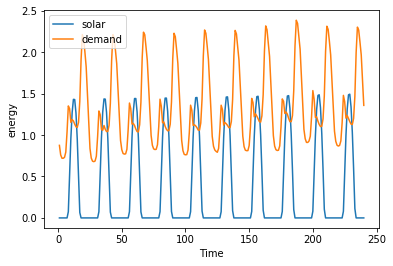

In [2]:
# Data loading and procesing
df = pd.read_csv('processed data.csv')
demand = df['Electricity:Facility [kW](Hourly)'].values
solar = df['Normalized Solar Energy [kWh]'].values

T = 240
demand = demand[:T]
solar = solar[:T]

solar_extend = np.append(solar,np.zeros(T))
demand_extend = np.append(demand,np.zeros(T))

t = np.arange(1,T+1)
plt.figure()
plt.xlabel('Time')
plt.ylabel('energy')
plt.plot(t,solar,label='solar')
plt.plot(t,demand,label='demand')
plt.legend()
plt.show()

In [3]:
# Parameters
C = 5.
xi = np.array([3.5,3.4,3.2,3.3,3.4,3.3,3.4,4.1,3.8,4.0,4.0,4.4,4.2,4.1,3.9,3.9,4.7,5.6,5.1,4.5,4.0,3.4,3.4,3.0])
xi = np.tile(xi,T//len(xi))
xi_extend = np.append(xi,np.zeros(T))
sigma = 2.5
pi = 3

In [4]:
def inequality_matrix(W=0):
    '''
    This function is meant to form a linear programming (sub)problem
    A: The inequality constraint matrix
    b: The inequality constraint bound
    c: The cost function
    '''
    if W <= 0:
        print('Prediction window too short!')
        A = np.array([])
        return A
    
    elif W >= T:
        W = T
        print('Prediction window longer than time length--consider it as offline!')
        
    else:
        pass
    
    # Define the inequality matrix
    A1 = np.zeros((1*W,3*W))
    A2 = np.zeros((1*W,3*W))
    A3 = np.zeros((1*W,3*W))
    for i in range(W):
        A1[i,i*3] = -1.
        A1[i,i*3+1] = 1.
        A1[i,i*3+2] = -1.
        if i >= 1:
            A2[i,:] = A2[i-1,:]
            A3[i,:] = A3[i-1,:]
        A2[i,i*3+1] = 1.
        A3[i,i*3+1] = -1.
        A2[i,i*3+2] = -1.
        A3[i,i*3+2] = 1.
    A4 = -np.eye(3*W)
    A = np.concatenate((A1, A2), axis=0)
    A = np.concatenate((A, A3), axis=0)
    A = np.concatenate((A, A4), axis=0)  
    return A

In [5]:
def inequality_bound(W=0,t=0,s0=0.):
    '''
    inequality bound is an online variable
    it changes according to time t and starting point s0
    '''
    if W <= 0:
        print('Prediction window too short!')
        b = np.array([])
        return b
    
    elif W >= T:
        print('Prediction window longer than time length--consider it as offline!')
        W = T
        # Define the inequality bound
        b1 = solar - demand
        
    else:
        if t-1>=0:
            b1 = solar_extend[t-1:t+W-1] - demand_extend[t-1:t+W-1]
        else:
            b1 = np.append(solar_extend[t-1:],solar_extend[:t+W-1]) - np.append(demand_extend[t-1:],demand_extend[:t+W-1])
    
    b2 = np.ones(W)*(C-s0)
    b3 = np.ones(W)*(s0)
    b4 = np.zeros(3*W)
    b = np.append(b1,b2)
    b = np.append(b,b3)
    b = np.append(b,b4) 
    
    return b

In [6]:
def cost(W=0,t=0):
    
    if W <= 0:
        print('Prediction window too short!')
        c = np.array([])
        return c
    elif W>=T:
        print('Prediction window longer than time length--consider it as offline!')
        W = T
    else:
        pass
    c = np.zeros(3*W)
    # Define the cost function
    for i in range(W):
        c[3*i] = xi_extend[t-1+i]+sigma
        c[3*i+1] = pi-sigma
        c[3*i+2] = pi+sigma
        
    return c

In [7]:
def transformed_cost(x):
    
    # Define the cost function
    c = np.sum(np.multiply(xi + sigma , np.maximum(demand - solar + x, 0)) + pi * np.absolute(x) - sigma * x)
        
    return c

In [8]:
# Receding Horizon Control
def RHC(W=0,s0=0.):
    '''
    r - charging/discharging from t to t+W-1
    s - state of charge from t to t+W-1
    rhc - output at t
    '''
    A_t = inequality_matrix(W=W)
    ACVX_t = matrix(A_t)
    ACVXSP_t = sparse(ACVX_t)
    s = np.zeros(W)
    rhc = np.zeros(T)
    
    if W<=0:
        print('Please starts with positive window size!')
        return rhc
    
    print('Prediction window: %d, RHC starts......' % (W))
    
    for t in range(2-W,T+1):
        # Solve sub-problem
        b_t = inequality_bound(W=W,t=t,s0=s0)
        bCVX_t = matrix(b_t)
        c_t = cost(W=W,t=t)
        cCVX_t = matrix(c_t)
        sol=solvers.lp(cCVX_t,ACVXSP_t,bCVX_t,solver='glpk')
        x = np.array(sol['x'])
        r = x[1::3]-x[2::3]
        if t<1:
            for tau in range(W):
                s[tau] = s0 + sum(r[:tau+1])
        else:
            for tau in range(W):
                s[tau] = s0 + sum(r[:tau+1])
                rhc[t-1] = s[0]
        # Update initial point
        s0 = s[0]
        
        if t%1000 == 0:
            temp_rhc = np.append(s0,rhc[:T-1])
            f = transformed_cost(rhc - temp_rhc)
            print('Iteration: %d, Total: %d, cost: %f ' %(t,T,f))
            
    temp_rhc = np.append(s0,rhc[:T-1])
    f = transformed_cost(rhc - temp_rhc)
    print('RHC finished! total cost: %f' %(f))

    return rhc

In [35]:
# Averaging Fixed Horizon Control
def AFHC(W=0,s0=0.):
    '''
    This is an algorithm developed by Lin et al in 2012
    It is a variant of FHC but take average
    '''
    A_t = inequality_matrix(W=W)
    ACVX_t = matrix(A_t)
    ACVXSP_t = sparse(ACVX_t)
    c_t = cost(W=W)
    cCVX_t = matrix(c_t)
    s = np.zeros(W)
    state = np.zeros(W)
    afhc = np.zeros(T)
    
    if W<=0:
        print('Please starts with positive window size!')
        return arhc
    
    print('Prediction window: %d, ARHC starts......' % (W))

    for t in range(2-W,T+1):
        b_t = inequality_bound(W=W,t=t,s0=s0)
        bCVX_t = matrix(b_t)
        # Solve sub-problem
        sol=solvers.lp(cCVX_t,ACVXSP_t,bCVX_t,solver='glpk')
        x = np.array(sol['x'])
        r = x[1::3]-x[2::3]
        # Discussion: Initial s matrix unitl t=1; then update s as a queue
        if t<1:
            # Record the solution of current sub-problem
            for tau in range(W):
                state[tau] = s0 + sum(r[:tau+1])
        else:
            # Update s and output
            for tau in range(W):
                state[tau] = s0 + sum(r[:tau+1]) 
                
            # Update initial point
            s0 = s[0][-1]
            s = np.roll(s, 1, axis=0) # To dequeue and enqueue next time!
            afhc[t-1] = afhc[t-1]/W
            
        if t%1000 == 0:
            print('Iteration: %d, Total: %d' %(t,T))
            
    
            
    return afhc

In [71]:
# Averaging Receding Horizon Control
def ARHC(W=0,s0=0.):
    '''
    This is an algorithm developed by myself!
    It is a variant of RHC but take average
    '''
    A_t = inequality_matrix(W=W)
    ACVX_t = matrix(A_t)
    ACVXSP_t = sparse(ACVX_t)
    c_t = cost(W=W)
    cCVX_t = matrix(c_t)
    s = np.zeros(W)
    state = np.zeros(W)
    arhc = np.zeros(T)
    
    if W<=0:
        print('Please starts with positive window size!')
        return arhc
    
    print('Prediction window: %d, ARHC starts......' % (W))

    for t in range(2-W,T+1):
        b_t = inequality_bound(W=W,t=t,s0=s0)
        bCVX_t = matrix(b_t)
        # Solve sub-problem
        sol=solvers.lp(cCVX_t,ACVX_t,bCVX_t,solver='glpk')
        x = np.array(sol['x'])
        r = x[1::3]-x[2::3]

        if t<1:
            # Record the solution of current sub-problem
            for tau in range(W):
                state[tau] = s0 + sum(r[:tau+1])
            # Update initial point
            s0 = state[0]
            s = np.vstack((s,state))
        else:
            # Update s and output
            for tau in range(W):
                state[tau] = s0 + sum(r[:tau+1]) 
            # Update initial point
            s0 = state[0]
            s = np.vstack((s,state))
            for tau in range(W):    
                arhc[t-1] += s[tau][W-tau-1]
            arhc[t-1] = arhc[t-1]/W
        
        
        if t%1000 == 0:
            print('Iteration: %d, Total: %d' %(t,T))
            
         
    s = np.delete(s,(0),axis=0)
            
    return arhc

In [46]:
# Implementing the algorithms
s0 = 0.
win = 25
x_RHC = np.zeros(T)
f_RHC = np.zeros(win-1)
x_ARHC = np.zeros(T)
f_ARHC = np.zeros(win-1)
for W in range(1,win):
    rhc = RHC(W=W, s0=s0)
    x_RHC = np.vstack([x_RHC,rhc])
    temp_rhc = np.append(s0,rhc[:T-1])
    f_RHC[W-1] = transformed_cost(rhc - temp_rhc)
    arhc = ARHC(W=W, s0=s0)
    x_ARHC = np.vstack([x_ARHC,arhc])
    temp_arhc = np.append(s0,arhc[:T-1])
    f_ARHC[W-1] = transformed_cost(arhc - temp_arhc)

Prediction window: 1, RHC starts......
Iteration: 1000, Total: 8760
Iteration: 2000, Total: 8760
Iteration: 3000, Total: 8760
Iteration: 4000, Total: 8760
Iteration: 5000, Total: 8760
Iteration: 6000, Total: 8760
Iteration: 7000, Total: 8760
Iteration: 8000, Total: 8760
Prediction window: 1, ARHC starts......
Iteration: 1000, Total: 8760
Iteration: 2000, Total: 8760
Iteration: 3000, Total: 8760
Iteration: 4000, Total: 8760
Iteration: 5000, Total: 8760
Iteration: 6000, Total: 8760
Iteration: 7000, Total: 8760
Iteration: 8000, Total: 8760
Prediction window: 2, RHC starts......
Iteration: 0, Total: 8760
Iteration: 1000, Total: 8760
Iteration: 2000, Total: 8760
Iteration: 3000, Total: 8760
Iteration: 4000, Total: 8760
Iteration: 5000, Total: 8760
Iteration: 6000, Total: 8760
Iteration: 7000, Total: 8760
Iteration: 8000, Total: 8760
Prediction window: 2, ARHC starts......
Iteration: 0, Total: 8760
Iteration: 1000, Total: 8760
Iteration: 2000, Total: 8760
Iteration: 3000, Total: 8760
Iterati

Iteration: 6000, Total: 8760
Iteration: 7000, Total: 8760
Iteration: 8000, Total: 8760
Prediction window: 15, RHC starts......
Iteration: 0, Total: 8760
Iteration: 1000, Total: 8760
Iteration: 2000, Total: 8760
Iteration: 3000, Total: 8760
Iteration: 4000, Total: 8760
Iteration: 5000, Total: 8760
Iteration: 6000, Total: 8760
Iteration: 7000, Total: 8760
Iteration: 8000, Total: 8760
Prediction window: 15, ARHC starts......
Iteration: 0, Total: 8760
Iteration: 1000, Total: 8760
Iteration: 2000, Total: 8760
Iteration: 3000, Total: 8760
Iteration: 4000, Total: 8760
Iteration: 5000, Total: 8760
Iteration: 6000, Total: 8760
Iteration: 7000, Total: 8760
Iteration: 8000, Total: 8760
Prediction window: 16, RHC starts......
Iteration: 0, Total: 8760
Iteration: 1000, Total: 8760
Iteration: 2000, Total: 8760
Iteration: 3000, Total: 8760
Iteration: 4000, Total: 8760
Iteration: 5000, Total: 8760
Iteration: 6000, Total: 8760
Iteration: 7000, Total: 8760
Iteration: 8000, Total: 8760
Prediction window:

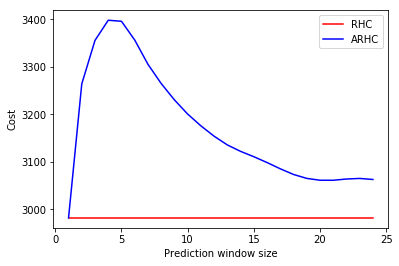

In [47]:
w = np.arange(1,win)
plt.figure()
plt.xlabel('Prediction window size')
plt.ylabel('Cost')
plt.plot(w,f_RHC,'-r',label='RHC')
plt.plot(w,f_ARHC,'-b',label='ARHC')
plt.legend()
plt.show()

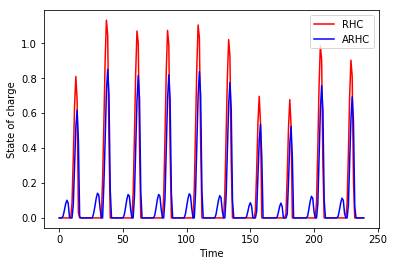

In [48]:
tau = np.arange(0,240)
plt.figure()
plt.xlabel('Time')
plt.ylabel('State of charge')
plt.plot(tau,x_RHC[8][0:240],'-r',label='RHC')
plt.plot(tau,x_ARHC[8][0:240],'-b',label='ARHC')
plt.legend()
plt.show()